In [32]:
cd /kaggle/input/pokemon-images-and-types/images/

/kaggle/input/pokemon-images-and-types/images


In [33]:
dir = "images/"

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio

In [35]:
def load_pokemon():
    data = []
    for i in os.listdir(dir):
        
        img = imageio.imread(dir + i)
        img = Image.fromarray(img)
        img.load()
        
        if(len(img.split()) == 4):
        
        # replace alpha channel with white color
            im = Image.new('RGB', img.size, (255, 255, 255))
            im.paste(img, mask=img.split()[3])
           
        
        else:
            im = img
        pixels = tf.keras.preprocessing.image.img_to_array(im)
        pixels = pixels.astype("float32")
        pixels /= 255.
        data.append(pixels)
    return np.stack(data)

In [36]:
dataset = load_pokemon()

In [37]:
dataset.shape

(809, 120, 120, 3)

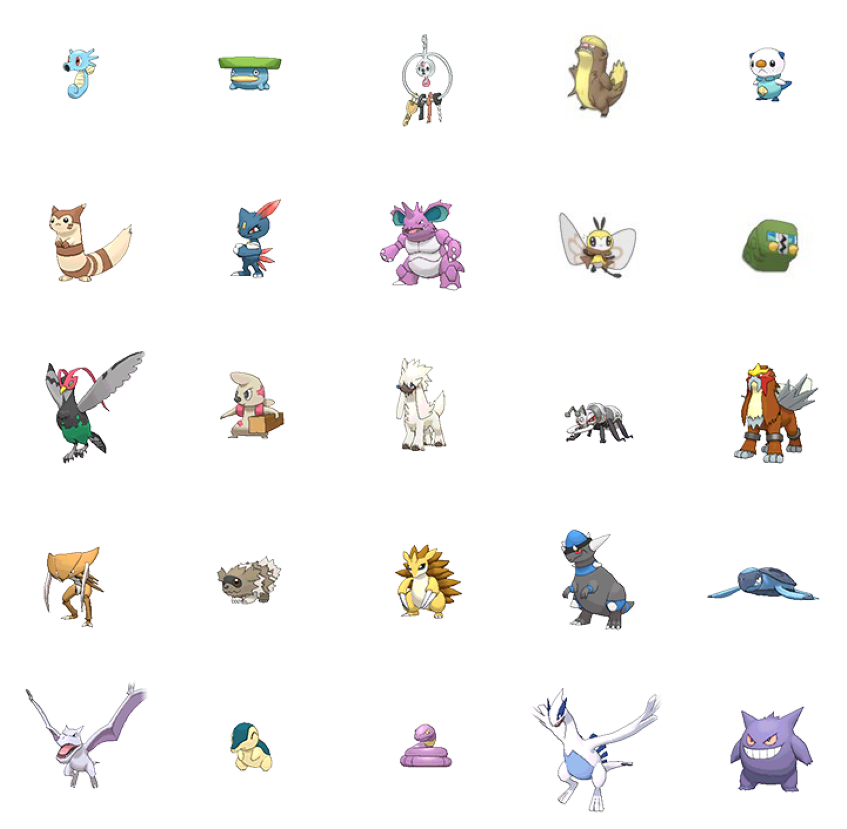

In [38]:
plt.figure(figsize = (15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.imshow(dataset[i])
plt.show()

In [39]:
def discriminator2(inp_shape = (120,120,3)):
    tf.keras.backend.clear_session()
    base_model = tf.keras.applications.MobileNetV2(input_shape = inp_shape, include_top = False, weights="imagenet")
    base_model.trainable = True
    glob_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    pred_layer = tf.keras.layers.Dense(1, "sigmoid")
    model = tf.keras.models.Sequential([base_model,
            glob_avg_pool,
            pred_layer])
    model.compile(optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5), loss = "binary_crossentropy", metrics = ['acc'])
    return model

In [40]:
def discriminator(inp_shape = (120,120,3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3,3), strides = (2,2), padding="same", input_shape = inp_shape),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2D(128, (3,3), padding="same",  strides = (2,2)),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2D(64, (3,3), padding="same",  strides = (2,2)),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2D(64, (3,3), padding = "same", strides = (2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5), loss = "binary_crossentropy", metrics = ['acc'])
    return model

In [41]:
d_model = discriminator()

In [42]:
d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 60, 128)       3584      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        73792     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)         

In [43]:
cd /kaggle/working

/kaggle/working


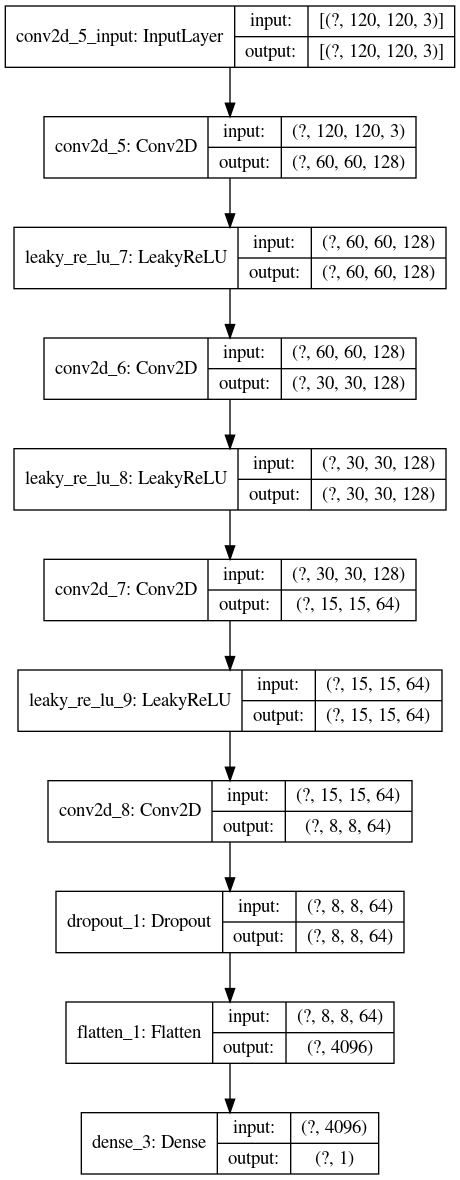

In [44]:
tf.keras.utils.plot_model(d_model, show_shapes = True)

In [45]:
def generate_fake_samples(n_samples):
    rand_samp = np.random.randn(120 * 120 * 3 * n_samples)
    rand_samp = -1 + rand_samp * 2
    X = rand_samp.reshape(n_samples, 120, 120, 3)
    y = np.zeros(shape = (n_samples,1))
    return X,y

In [46]:
def train_discriminator(model, dataset, num_iterations = 20, n_batch = 128):
    half_batch = int(n_batch/2)
    for i in range(num_iterations):
        X_real, y_real = generate_real_samples(dataset, half_batch)
       
        _, real_acc = model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(half_batch)
      
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print("Batch {}: Real acc: {} and Fake acc: {}".format(i+1, real_acc*100, fake_acc* 100))

In [47]:
train_discriminator(d_model, dataset)

Batch 1: Real acc: 96.875 and Fake acc: 12.5
Batch 2: Real acc: 100.0 and Fake acc: 98.4375
Batch 3: Real acc: 100.0 and Fake acc: 100.0
Batch 4: Real acc: 100.0 and Fake acc: 100.0
Batch 5: Real acc: 100.0 and Fake acc: 100.0
Batch 6: Real acc: 100.0 and Fake acc: 100.0
Batch 7: Real acc: 100.0 and Fake acc: 100.0
Batch 8: Real acc: 100.0 and Fake acc: 100.0
Batch 9: Real acc: 100.0 and Fake acc: 100.0
Batch 10: Real acc: 100.0 and Fake acc: 100.0
Batch 11: Real acc: 100.0 and Fake acc: 100.0
Batch 12: Real acc: 100.0 and Fake acc: 100.0
Batch 13: Real acc: 100.0 and Fake acc: 100.0
Batch 14: Real acc: 100.0 and Fake acc: 100.0
Batch 15: Real acc: 100.0 and Fake acc: 100.0
Batch 16: Real acc: 100.0 and Fake acc: 100.0
Batch 17: Real acc: 100.0 and Fake acc: 100.0
Batch 18: Real acc: 100.0 and Fake acc: 100.0
Batch 19: Real acc: 100.0 and Fake acc: 100.0
Batch 20: Real acc: 100.0 and Fake acc: 100.0


In [48]:
X_real, y_real = generate_real_samples(dataset,800)
X_fake, y_fake = generate_fake_samples(800)
X,y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

In [49]:
history = d_model.fit(X,y, epochs = 5)

Train on 1600 samples
Epoch 1/5
1600/1600 [==============================] - 1s 780us/sample - loss: 4.5569e-04 - acc: 1.0000
Epoch 2/5
1600/1600 [==============================] - 1s 616us/sample - loss: 1.4146e-04 - acc: 1.0000
Epoch 3/5
1600/1600 [==============================] - 1s 621us/sample - loss: 6.5254e-05 - acc: 1.0000
Epoch 4/5
1600/1600 [==============================] - 1s 593us/sample - loss: 3.8439e-05 - acc: 1.0000
Epoch 5/5
1600/1600 [==============================] - 1s 579us/sample - loss: 2.6682e-05 - acc: 1.0000


In [50]:
history

In [51]:
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [53]:
def generator(latent_dim = 100):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128 * 15 * 15, input_dim = latent_dim),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Reshape((15,15,128)),
        
        # 30 * 30
        tf.keras.layers.Conv2DTranspose(128, (3,3), strides = (2,2), padding = "same"),
        tf.keras.layers.LeakyReLU(0.2),
        
        #60 * 60
        tf.keras.layers.Conv2DTranspose(128, (3,3), strides = (2,2), padding = "same"),
        tf.keras.layers.LeakyReLU(0.2),
        
        # 120 * 120
        tf.keras.layers.Conv2DTranspose(64, (3,3), strides = (2,2), padding = "same"),
        tf.keras.layers.LeakyReLU(0.2),
        
        tf.keras.layers.Conv2D(3, (3,3), padding = "same", activation = "sigmoid")
        
    ])
    return model

In [54]:
d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 60, 128)       3584      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        73792     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)         

In [55]:
g_model = generator()

In [56]:
g_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 28800)             2908800   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 28800)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 30, 30, 128)       147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 60, 60, 128)       147584    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 60, 60, 128)      

In [57]:
def generate_real_samples(dataset, n_size = 128):
    ind = np.random.randint(0, dataset.shape[0], n_size)
    data = dataset[ind]
    y = np.ones((n_size, 1))
    return data, y

In [58]:
# plt.imshow(generate_fake_examples(g_model)[0][3])

In [59]:
def generate_latent_space(n_size = 128, latent_dim = 100):
    points = np.random.randn(n_size * latent_dim)
    points = points.reshape((n_size, latent_dim))
    return points

In [60]:
def generate_fake_examples(g_model, n_size = 128, latent_dim = 100):
    latent_space = generate_latent_space(n_size, latent_dim)
    preds = g_model.predict(latent_space)
    y = np.zeros((n_size , 1))
    return preds, y

In [61]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = tf.keras.models.Sequential([
        g_model,
        d_model
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5), loss = "binary_crossentropy")
    return model

In [62]:
gan_model = gan(g_model, d_model)

In [63]:
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 120, 120, 3)       3279491   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 265985    
Total params: 3,545,476
Trainable params: 3,279,491
Non-trainable params: 265,985
_________________________________________________________________


In [105]:
def plot_samples(data):
    plt.figure(figsize = (15,15))
    for i in range(5*5):
        plt.subplot(5,5,i+1)
        plt.axis("off")
        plt.imshow(data[i])
    plt.savefig("Pokemnon.jpg")
    plt.show()
    

In [65]:
def summarize_performance(g_model, dataset, n_size = 128):
    X_real, y_real = generate_real_samples(dataset)
    _,accr = d_model.evaluate(X_real, y_real)
    
    X_fake, y_fake = generate_fake_examples(g_model)
    _, accf = d_model.evaluate(X_fake, y_fake)
    
    print("Real samples Acc: {}".format(accr*100))
    print("Fake samples Acc: {}".format(accf*100))
    
    plot_samples(X_fake)
    

In [66]:
cd 

/root


In [67]:
cd /kaggle/working

/kaggle/working


In [71]:
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	plt.subplot(2, 1, 1)
	plt.plot(d1_hist, label='d-real')
	plt.plot(d2_hist, label='d-fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	# plot discriminator accuracy
	plt.subplot(2, 1, 2)
	plt.plot(a1_hist, label='acc-real')
	plt.plot(a2_hist, label='acc-fake')
	plt.legend()
	# save plot to file
	plt.close()

In [74]:
def train(g_model, d_model, gan_model, dataset,epochs = 1500, latent_dim = 100, batch_size = 128):
    half_batch = int(batch_size/2)
    batch_per_epoch = int(len(dataset)/batch_size)
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    for i in range(epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_examples(g_model, half_batch)
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_latent_space()
            y_gan = np.ones((batch_size, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            d1_hist.append(d_loss1)
            d2_hist.append(d_loss2)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
            
            if((j+1) % 5 == 0):
                print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
                    (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
        
        if((i+1) % 50 == 0):
            summarize_performance(g_model, dataset)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
            

In [87]:
# Trained for 1500 epochs
train(g_model, d_model, gan_model, dataset)

>1, d1=0.041, d2=0.065 g=5.053, a1=100, a2=98
>2, d1=0.058, d2=0.104 g=5.241, a1=100, a2=98
>3, d1=0.070, d2=0.149 g=5.745, a1=100, a2=96
>4, d1=0.104, d2=0.038 g=4.466, a1=100, a2=100
>5, d1=0.039, d2=0.074 g=5.198, a1=98, a2=98


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f838fd01c20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


>6, d1=0.057, d2=0.091 g=5.277, a1=100, a2=98
>7, d1=0.309, d2=0.175 g=4.773, a1=89, a2=93
>8, d1=0.797, d2=0.850 g=6.524, a1=57, a2=65
>9, d1=3.288, d2=3.239 g=3.874, a1=21, a2=17
>10, d1=0.686, d2=0.906 g=3.851, a1=65, a2=65
>11, d1=0.815, d2=0.692 g=2.635, a1=62, a2=70
>12, d1=0.391, d2=0.654 g=3.190, a1=79, a2=71
>13, d1=0.520, d2=0.613 g=2.876, a1=70, a2=67
>14, d1=0.190, d2=0.276 g=3.425, a1=90, a2=89


KeyboardInterrupt: 

In [77]:
g_model.save("pokemon.h5")

## Vizualizaing Generated Pokemons 

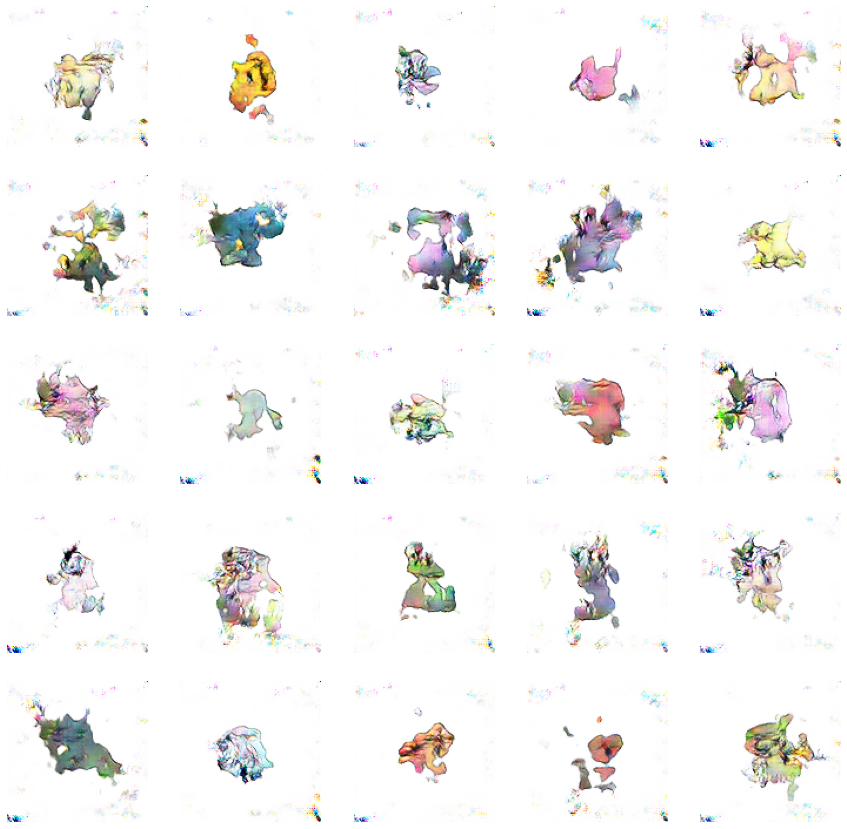

In [100]:
g_model = tf.keras.models.load_model('pokemon.h5')
X_input = generate_latent_space(n_size = 25)
preds = g_model.predict(X_input)
plot_samples(preds)

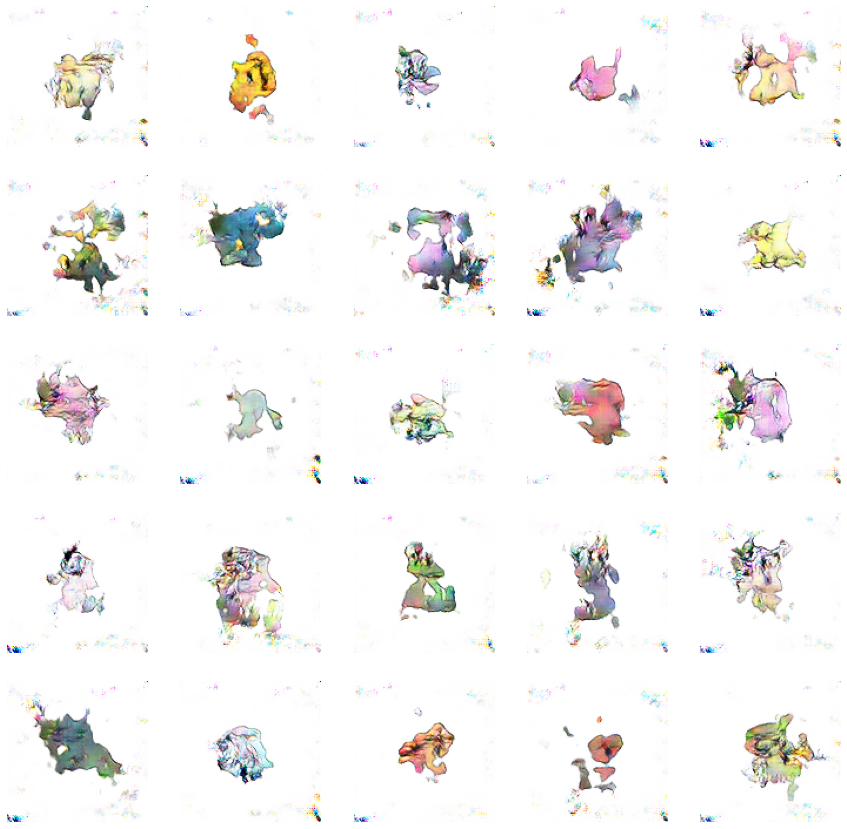

<Figure size 432x288 with 0 Axes>

In [106]:
plot_samples(preds)
plt.savefig("POkemnon.jpg")